<h1> Working with weather data</h1>
In this notebook we will explore how to extract and process weather data from different observatories.<br>

We will work with two types of observatories which are the individual observatiries scattered around the world (but focusing on the Walney Island observatory) and the [Copernicus](https://climate.copernicus.eu/) mission.<br>

<h3>Walney island observatory data </h3>
Some websites like [Ogimet](https://www.ogimet.com/) provide a compilation of weather data that is gathered from individual stations around the world. <br>

Since the website

In [1]:
import requests
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Importing and setting seaborn.
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale=1.2)

In [ ]:
# Some examples to build the url:
# As a crazy number soup:
#url = 'https://www.ogimet.com/display_synops2.php?lang=en&lugar=03214&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=08&day=22&hora=18&anof=2021&mesf=08&dayf=23&horaf=18&send=send'
# As a txt file (which I need to install yet another module so pandas can read anwyay).
#url = 'https://www.ogimet.com/display_synops2.php?lang=en&lugar=03214&tipo=ALL&ord=DIR&nil=SI&fmt=txt&ano=2021&mes=08&day=23&hora=12&anof=2021&mesf=08&dayf=24&horaf=12&send=send'
# Will stick with this one though seems better parsed.
# url = 'https://www.ogimet.com/cgi-bin/gsynres?lang=en&ind=03214&ndays=30&ano=2008&mes=06&day=09&hora=02&ord=DIR&Send=Send'
for year in range(2008,2022):
    for month in [f'{x:02}' for x in range(13)]:
        for hour in [f'{x:02}' for x in range(24)]:
            url = f'https://www.ogimet.com/cgi-bin/gsynres?lang=en&ind=03214&ndays=31&ano={year}&mes={month}&day=01&hora={hour}&ord=DIR&Send=Send'
            html = requests.get(url).content
            df_list = pd.read_html(html,parse_dates=False)
            df = df_list[-1]
            if len(df) > 0:
                df.columns = df.columns.droplevel()
                df['timestamp'] = np.nan
                for index, row in df.iterrows():
                    try:
                        timestamp = pd.to_datetime(f'{year}{month}{row.Date[-2:]}{hour}', 
                                                   format='%Y%m%d%H')
                    except ValueError:
                        pass
                    else:
                        df.loc[index,'timestamp'] = timestamp
                df['year'] = year
                df['month'] = month
                df['hour'] = hour
                df.to_csv(f'WalneyIsland/{year}{month}01_{hour}.csv')
            else:
                print(f'No entries for {year} {month} {hour}')

In [ ]:
df = pd.concat([pd.read_csv(frame) for frame in glob('WalneyIsland/*.csv')])
df.head()

In [ ]:
df = df.drop(['Unnamed: 0', 'Dailyweather summary', 'Dailyweather summary.1',
       'Dailyweather summary.2', 'Dailyweather summary.3',
       'Dailyweather summary.4', 'Dailyweather summary.5',
       'Dailyweather summary.6', 'Dailyweather summary.7'], axis=1)


In [ ]:
#Further formatting the Dataframe.
df = df.reset_index()
df = df.drop(['index'], axis=1)
df = df.replace('----',np.nan)
df = df.replace('-----',np.nan)

# Making sure format types are appropriate.
df.VisKm = df.VisKm.astype(float)
df.Max = df.Max.astype(float)
df.Min = df.Min.astype(float)
df.Avg = df.Avg.astype(float)
df['Int.'] = df['Int.'].astype(float)
df.head()

As an example of what can be done with this data, let us use the weather data to check visibility across the Morecambe bay.

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(df.VisKm)
plt.title('Hourly sampled visibility - Walney Island')
plt.xlabel('Visibility (km)')
plt.ylabel('Frequency')

Is this visibility enough to connect the hospitals across the bay? [G-Maps](https://www.google.com/maps/search/hospital/@54.1072887,-2.9396936,11z) <br>

It is also important to be mindful of the fact the weather condictions can vary drastically across the seasons and has been changing over the years.<br>

<h1> Working with Copernicus data</h1>

Now we will see how to download and work with Copernicus data. This data is made available in .grib format which is often used to store weather data. <br>

In [2]:
import cdsapi
import xarray as xr
import cfgrib

The typical download query for Copernicus can be written as follows (see the [CDS API](https://cds.climate.copernicus.eu/api-how-to) documentation). it is necessary to register as an user in order to have access to a personal download key.

In [3]:
c = cdsapi.Client()
c.retrieve("reanalysis-era5-pressure-levels",
{
"variable": "temperature",
"pressure_level": "1000",
"product_type": "reanalysis",
"year": "2021",
"month": "12",
"day": "25",
"time": "12:00",
"format": "grib",
'area': [55.35, -3.51, 53.22, -2.39]
}, "temperaturesample.grib")

2022-03-29 13:34:23,206 INFO Welcome to the CDS
2022-03-29 13:34:23,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2022-03-29 13:34:23,267 INFO Request is queued


HTTPError: 404 Client Error:  for url: https://cds.climate.copernicus.eu/api/v2/tasks/1dc5717f-dc80-4305-a2e9-7faf126d77bb

In [5]:
c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'grib',
        'variable': 'total_precipitation',
        'year': '2021',
        'month': '12',
        'day': '25',
        'time': '12:00',
        'area': [
            55.35, -3.51, 53.22,
            -2.39,
        ],
    },
    'totalprecipitation.grib')

2022-03-29 14:21:09,145 INFO Welcome to the CDS
2022-03-29 14:21:09,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-03-29 14:21:09,217 INFO Request is queued
2022-03-29 14:55:31,334 INFO Request is completed
2022-03-29 14:55:31,336 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.mars.internal-1648562104.4370217-26633-8-9aba25ca-9633-41aa-b543-10a7863f95a7.grib to totalprecipitation.grib (840)
2022-03-29 14:55:31,633 INFO Download rate 2.8K/s                                                                     


Result(content_length=840,content_type=application/x-grib,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.mars.internal-1648562104.4370217-26633-8-9aba25ca-9633-41aa-b543-10a7863f95a7.grib)

In [20]:
c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'grib',
        'variable': 'total_precipitation',
        'year': '2021',
        'month': '12',
        'day': '25',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            55.35, -3.51, 53.22,
            -2.39,
        ],
    },
    'download.grib')

2022-03-30 12:12:41,413 INFO Welcome to the CDS
2022-03-30 12:12:41,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-03-30 12:12:41,495 INFO Request is queued
2022-03-30 13:23:07,956 INFO Request is completed
2022-03-30 13:23:07,991 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data8/adaptor.mars.internal-1648642913.388938-6379-1-292a6f3e-6b05-4027-b50e-7df56f44d5ee.grib to download.grib (19.7K)
2022-03-30 13:23:08,290 INFO Download rate 65.8K/s                                                                    


Result(content_length=20160,content_type=application/x-grib,location=https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data8/adaptor.mars.internal-1648642913.388938-6379-1-292a6f3e-6b05-4027-b50e-7df56f44d5ee.grib)

In [6]:
# Now we open the file using xarray.
ds_grib = xr.open_dataset('totalprecipitation.grib', engine="cfgrib")

In [8]:
ds_grib.dims

Frozen({'latitude': 22, 'longitude': 12})

In [7]:
ds_grib.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:     (latitude: 22, longitude: 12)
Coordinates:
    number      int32 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     int32 ...
  * latitude    (latitude) float64 55.32 55.22 55.12 55.02 ... 53.42 53.32 53.22
  * longitude   (longitude) float64 -3.51 -3.41 -3.31 ... -2.61 -2.51 -2.41
    valid_time  datetime64[ns] ...
Data variables:
    tp          (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-03-29T14:57:47 GRIB to CDM+CF via cfgrib-0....>

Generally, there are two important elements in sattelite data one being the metada and the values array. The metadata should contain all the relevant information about the instrument and data collection (e.g., sampling, timestamps). The values array contains the values of what is being measured by the instrument in this case being the rainfall.<br>

Below we shall explore some aspects of the data in this datacube.

In [9]:
ds_grib.tp

<xarray.DataArray 'tp' (latitude: 22, longitude: 12)>
array([[3.165045e-05, 2.613539e-05, 2.341081e-05, ..., 4.200699e-05,
        4.908551e-05, 5.812143e-05],
       [2.774495e-05, 2.099752e-05, 1.577024e-05, ..., 3.939626e-05,
        4.902963e-05, 5.819850e-05],
       [2.407018e-05, 1.714720e-05, 1.175740e-05, ..., 4.134738e-05,
        5.204292e-05, 6.256547e-05],
       ...,
       [         nan,          nan,          nan, ..., 1.539316e-03,
        1.456664e-03, 1.350846e-03],
       [7.018148e-04, 8.076503e-04,          nan, ..., 1.352710e-03,
        1.296751e-03, 1.233391e-03],
       [4.949208e-04, 6.472407e-04, 7.855349e-04, ..., 1.152177e-03,
        1.101437e-03, 1.041616e-03]], dtype=float32)
Coordinates:
    number      int32 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     int32 ...
  * latitude    (latitude) float64 55.32 55.22 55.12 55.02 ... 53.42 53.32 53.22
  * longitude   (longitude) float64 -3.51 -3.41 -3.31 ... -2.61 -2.51 -2.41
    valid_time  datetime64[ns] ...
Attributes:
    GRIB_paramId:                             228
    GRIB_shortName:                           tp
    GRIB_units:                               m
    GRIB_name:                                Total precipitation
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    GRIB_missingValue:                        9999
    GRIB_numberOfPoints:                      264
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_NV:                                  0
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    GRIB_gridType:                            regular_ll
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_Nx:                                  12
    GRIB_iDirectionIncrementInDegrees:        0.1
    GRIB_iScansNegatively:                    0
    GRIB_longitudeOfFirstGridPointInDegrees:  -3.51
    GRIB_longitudeOfLastGridPointInDegrees:   -2.41
    GRIB_Ny:                                  22
    GRIB_jDirectionIncrementInDegrees:        0.1
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   55.32
    GRIB_latitudeOfLastGridPointInDegrees:    53.22
    long_name:                                Total precipitation
    units:                                    m

In [10]:
# Extracting the data from the xr object
datacube = ds_grib.tp
datacube

<xarray.DataArray 'tp' (latitude: 22, longitude: 12)>
array([[3.165045e-05, 2.613539e-05, 2.341081e-05, ..., 4.200699e-05,
        4.908551e-05, 5.812143e-05],
       [2.774495e-05, 2.099752e-05, 1.577024e-05, ..., 3.939626e-05,
        4.902963e-05, 5.819850e-05],
       [2.407018e-05, 1.714720e-05, 1.175740e-05, ..., 4.134738e-05,
        5.204292e-05, 6.256547e-05],
       ...,
       [         nan,          nan,          nan, ..., 1.539316e-03,
        1.456664e-03, 1.350846e-03],
       [7.018148e-04, 8.076503e-04,          nan, ..., 1.352710e-03,
        1.296751e-03, 1.233391e-03],
       [4.949208e-04, 6.472407e-04, 7.855349e-04, ..., 1.152177e-03,
        1.101437e-03, 1.041616e-03]], dtype=float32)
Coordinates:
    number      int32 0
    time        datetime64[ns] 2021-12-25
    step        timedelta64[ns] 12:00:00
    surface     int32 0
  * latitude    (latitude) float64 55.32 55.22 55.12 55.02 ... 53.42 53.32 53.22
  * longitude   (longitude) float64 -3.51 -3.41 -3.31 ... -2.61 -2.51 -2.41
    valid_time  datetime64[ns] 2021-12-25T12:00:00
Attributes:
    GRIB_paramId:                             228
    GRIB_shortName:                           tp
    GRIB_units:                               m
    GRIB_name:                                Total precipitation
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    GRIB_missingValue:                        9999
    GRIB_numberOfPoints:                      264
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_NV:                                  0
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    GRIB_gridType:                            regular_ll
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_Nx:                                  12
    GRIB_iDirectionIncrementInDegrees:        0.1
    GRIB_iScansNegatively:                    0
    GRIB_longitudeOfFirstGridPointInDegrees:  -3.51
    GRIB_longitudeOfLastGridPointInDegrees:   -2.41
    GRIB_Ny:                                  22
    GRIB_jDirectionIncrementInDegrees:        0.1
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   55.32
    GRIB_latitudeOfLastGridPointInDegrees:    53.22
    long_name:                                Total precipitation
    units:                                    m

In [12]:
# Showing the temporal sampling.
datacube.time

<xarray.DataArray 'time' ()>
array('2021-12-25T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    number      int32 0
    time        datetime64[ns] 2021-12-25
    step        timedelta64[ns] 12:00:00
    surface     int32 0
    valid_time  datetime64[ns] 2021-12-25T12:00:00
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [13]:
datacube.step

<xarray.DataArray 'step' ()>
array(43200000000000, dtype='timedelta64[ns]')
Coordinates:
    number      int32 0
    time        datetime64[ns] 2021-12-25
    step        timedelta64[ns] 12:00:00
    surface     int32 0
    valid_time  datetime64[ns] 2021-12-25T12:00:00
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

Plotting the data follows the same sort of syntax than what one can expect from a dataframe.

(array([120.,  20.,   6.,   9.,  11.,  14.,  12.,   8.,   5.,   4.]),
 array([5.5266191e-06, 2.3940587e-04, 4.7328512e-04, 7.0716435e-04,
        9.4104360e-04, 1.1749229e-03, 1.4088021e-03, 1.6426814e-03,
        1.8765606e-03, 2.1104398e-03, 2.3443191e-03], dtype=float32),
 <BarContainer object of 10 artists>)

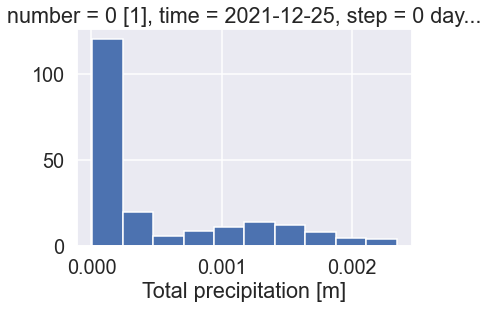

In [14]:
datacube.plot.hist()

(-0.0001, 0.001)

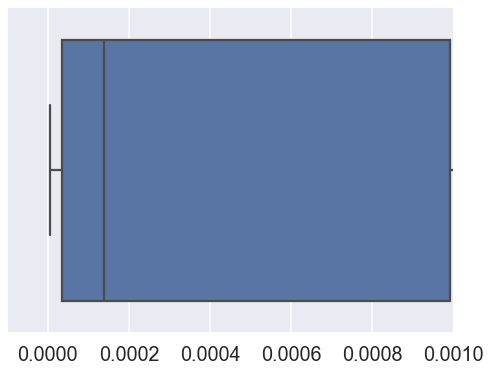

In [15]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x=datacube.values.flatten())
plt.xlim(-0.0001,0.001)

However this data is a datacube of sattelite images so geographical features can also be extracted from it.

In [16]:
from matplotlib import cm
import cartopy.crs as ccrs

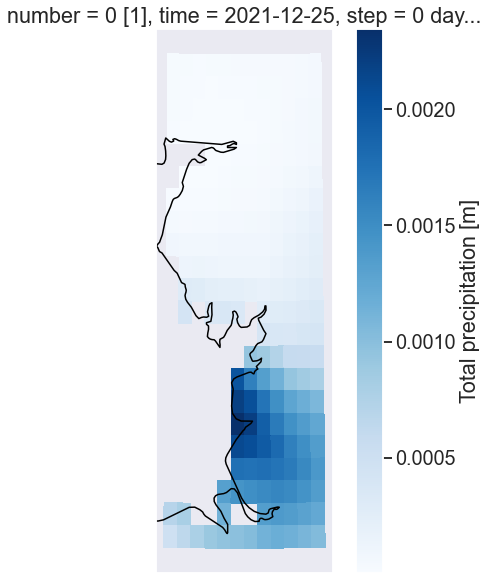

In [19]:
fig = plt.figure(figsize=(8, 10))
p = datacube.mean(dim=['time','step']).plot(transform=ccrs.PlateCarree(),
                                            cmap=cm.Blues,
    subplot_kws={
        'projection': ccrs.Orthographic(np.mean(datacube.longitude.values),
                                        np.mean(datacube.latitude.values))})

p.axes.coastlines()

In [18]:
fig = plt.figure(figsize=(8, 10))
p = datacube.sum(dim=['time','step']).plot(transform=ccrs.PlateCarree(),
                                            cmap=cm.Blues,
    subplot_kws={
        'projection': ccrs.Orthographic(np.mean(datacube.longitude.values),
                                        np.mean(datacube.latitude.values))})

p.axes.coastlines()

ValueError: 'time' not found in array dimensions ('latitude', 'longitude')

<Figure size 576x720 with 0 Axes>

If working with xarrays is being much of a nuissance the data can also be exported into a pandas dataframe. This comes with a price though as the outfile can be significantly larger and operations within the dataframe can take much longer than treating the data as an image. 

In [ ]:
somethingtomakethiscrash
# Word of advice, don't do this.
df = ds_grib.to_dataframe()